In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/brca.PD1.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,joined.PD1_data
0,71.806464,129.127076,1.158576,122.432688,194.239152,0.369681,0.664784,0.630319,6722.417551,6665.889385,...,162597,4593,24879,38851,43444,12789,27081,26708,39497,1
1,82.396624,168.316672,2.677280,145.747888,228.144512,0.361160,0.737763,0.638840,6594.895183,6647.129359,...,65822,3040,14794,24867,27907,1328,3955,6120,7448,1
2,26.877520,53.040932,3.571664,44.355952,71.233472,0.377316,0.744607,0.622684,5833.355998,6531.812070,...,45076,1546,7789,12735,14281,729,2571,4174,4903,1
3,43.128576,111.292004,0.742096,98.095856,141.224432,0.305390,0.788051,0.694610,7160.616676,7223.818109,...,44382,1897,5594,9934,11831,1837,2488,1965,3802,0
4,0.685216,2.596956,1.605504,8.142384,8.827600,0.077622,0.294186,0.922378,4479.384456,4093.277627,...,17273,452,1604,4450,4902,181,289,527,708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,9.903376,11.445204,0.085904,11.510544,21.413920,0.462474,0.534475,0.537526,5228.674659,6463.852141,...,7137,1701,1250,2016,3717,270,322,486,756,0
779,29.783936,47.477228,0.007680,23.035728,52.819664,0.563880,0.898855,0.436120,6143.226420,7334.381654,...,13332,1061,2049,1739,2800,3023,3154,735,3758,1
780,49.370816,87.116700,0.016976,62.198960,111.569776,0.442511,0.780827,0.557489,5869.237691,6358.235055,...,46429,8881,6618,5780,14661,3364,3586,1754,5118,1
781,11.947152,20.351728,1.422320,12.491184,24.438336,0.488869,0.832779,0.511131,5604.175185,5747.899181,...,18026,1739,2683,1693,3432,1439,1578,372,1811,1


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,0.773340,1.416390,-0.229111,2.225858,1.599272,-0.569869,0.024877,0.569869,0.380911,0.291782,...,1.181380,1.124431,0.609412,1.809491,1.796529,1.703210,1.910261,1.443385,1.063089,1.331446
1,1.049365,2.205295,-0.116624,2.892456,2.103572,-0.624353,0.456695,0.624353,0.224011,0.266921,...,0.096400,0.016887,0.112152,0.743285,0.853101,0.775746,-0.288591,-0.169642,-0.084746,-0.138731
2,-0.397699,-0.115259,-0.050379,-0.006410,-0.230285,-0.521048,0.497188,0.521048,-0.712967,0.114101,...,-0.139369,-0.220541,-0.366217,0.002702,0.034618,-0.037644,-0.403512,-0.266175,-0.193240,-0.255477
3,0.025873,1.057362,-0.259959,1.530051,0.810744,-0.980953,0.754244,0.980953,0.920060,1.031158,...,-0.219556,-0.228483,-0.253829,-0.229358,-0.154351,-0.183894,-0.190937,-0.271964,-0.316398,-0.305983
4,-1.080381,-1.130720,-0.196008,-1.041781,-1.158494,-2.437345,-2.167946,2.437345,-2.378858,-3.117482,...,-0.476162,-0.538733,-0.716508,-0.651189,-0.524328,-0.597513,-0.508649,-0.425343,-0.396570,-0.447913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,-0.840117,-0.952601,-0.308562,-0.945483,-0.971288,0.023467,-0.746160,-0.023467,-1.456951,0.024039,...,-0.613466,-0.654735,-0.316587,-0.688615,-0.688538,-0.668250,-0.491574,-0.423042,-0.398856,-0.445711
779,-0.321945,-0.227259,-0.314356,-0.615970,-0.504167,0.671875,1.409873,-0.671875,-0.331710,1.177678,...,-0.576393,-0.583836,-0.521511,-0.604143,-0.707225,-0.722990,0.036603,-0.225511,-0.384973,-0.308001
780,0.188572,0.570702,-0.313667,0.503734,0.369668,-0.104181,0.711502,0.104181,-0.668819,-0.115926,...,-0.328959,-0.205056,1.982401,-0.121099,-0.434600,-0.014960,0.102026,-0.195379,-0.328162,-0.245614
781,-0.786848,-0.773308,-0.209576,-0.917446,-0.926304,0.192245,1.018900,-0.192245,-0.994945,-0.924752,...,-0.549101,-0.530115,-0.304420,-0.537115,-0.710329,-0.685263,-0.267295,-0.335436,-0.405212,-0.397315


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

359


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/BRCA.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
# clusters

Number of Clusters: 20


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

261 261
261 261
261 261
0.45977011494252873
0.4559386973180077
0.45977011494252873


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(522, 607) (522,)
(261, 607) (261,)


In [128]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 20
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.646564244165378, 0.6582264337705966, 0.6790054424625394, 0.6952823103858938, 0.7000186914538119, 0.7273633163138342, 0.7166800534136761, 0.7418002008567519, 0.7238383525302619, 0.7530459570913097, 0.6617265126468654, 0.7043866592456318, 0.7242248462468227, 0.72003437783288, 0.7499456753586093, 0.7641033823477132, 0.7179063849784034, 0.7573682377486269, 0.5, 0.5]


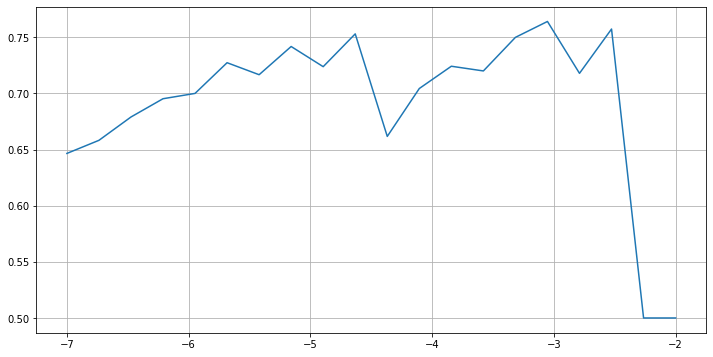

0.047234459484186364 -3.0526315789473686


In [26]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

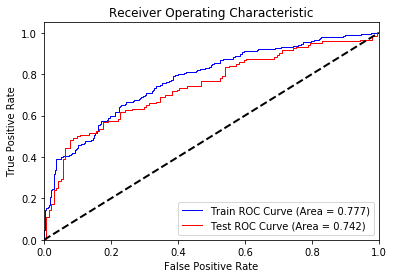

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

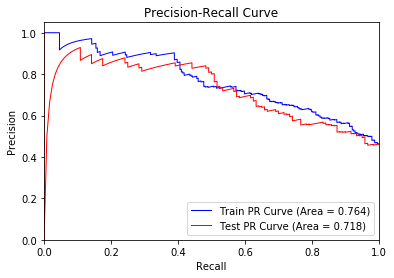

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 56


,HIF,Beta,Cluster
606,TOTAL [PLASMA CELLS] IN [TUMOR]_HE,0.061138,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,0.057136,1
413,DENSITY [PLASMA CELLS] IN [ESI_0080]_HE,0.053745,8
157,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.052188,8
166,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF PLASMA IN STROMA_HE,0.043557,8
46,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN STROMA_HE,0.036390,1
45,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN ESI_0080_HE,0.033535,1
47,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN TUMOR_HE,0.030320,1
405,DENSITY [LYMPHOCYTE CELLS] IN [ESI_0080]_HE,0.028485,8
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,0.025339,1


### Outer Loop 2

In [13]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(522, 607) (522,)
(261, 607) (261,)


In [ ]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.646564244165378, 0.6582264337705966, 0.6790054424625394, 0.6952823103858938, 0.7000186914538119, 0.7273633163138342, 0.7166800534136761, 0.7418002008567519, 0.7238383525302619, 0.7530459570913097, 0.6617265126468654, 0.7043866592456318, 0.7242248462468227, 0.72003437783288, 0.7499456753586093, 0.7641033823477132, 0.7179063849784034, 0.7573682377486269, 0.5, 0.5]


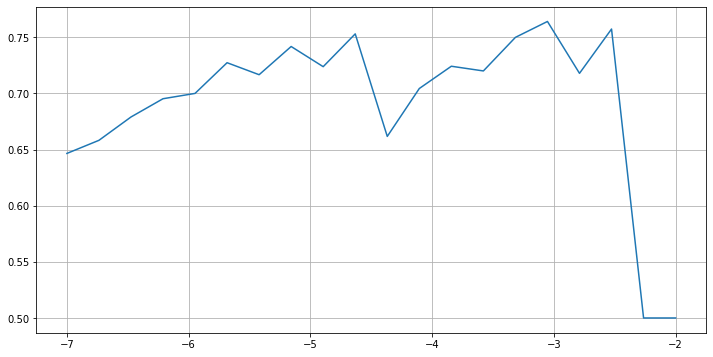

0.047234459484186364 -3.0526315789473686


In [50]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

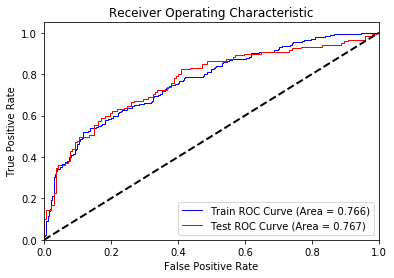

In [15]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

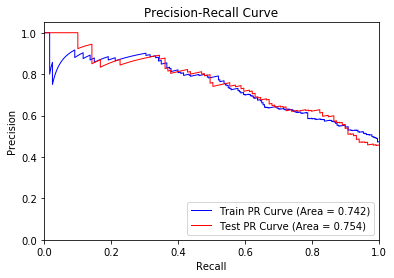

In [16]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 36


,HIF,Beta,Cluster
65,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF PLASMA IN ESI_0080_HE,0.364249,9
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.268812,9
25,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF PLASMA IN ESI_0080_HE,0.166507,9
287,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.147800,9
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.130620,9
67,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF PLASMA IN TUMOR_HE,0.124361,9
22,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF MACROPHAGE IN STROMA_HE,0.020126,8
162,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF MACROPHAGE IN STROMA_HE,0.019947,8
99,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF LYMPHOCYTE IN TUMOR_HE,0.016451,8
326,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [LY...,0.013744,8


### Outer Loop 3

In [18]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(522, 607) (522,)
(261, 607) (261,)


In [ ]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

In [ ]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

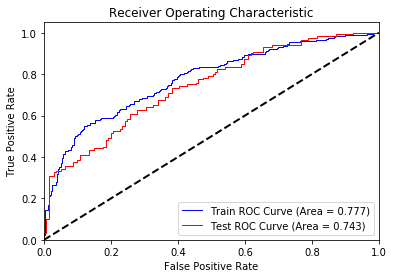

In [20]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

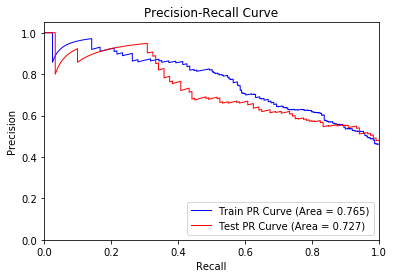

In [21]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 20


,HIF,Beta,Cluster
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.271743,9
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.233180,9
65,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF PLASMA IN ESI_0080_HE,0.187281,9
287,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.177742,9
326,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [LY...,0.030469,8
21,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF MACROPHAGE IN ESI_0080_HE,0.026204,8
25,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF PLASMA IN ESI_0080_HE,0.025002,9
26,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF PLASMA IN STROMA_HE,0.021245,8
167,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF PLASMA IN TUMOR_HE,0.020509,8
178,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN STROMA_HE,0.016378,8


## Compute Ensemble Model

In [23]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
65,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF PLASMA IN ESI_0080_HE,0.000000,0.364249,0.187281,9,0.183843
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.000000,0.268812,0.271743,9,0.180185
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.000000,0.130620,0.233180,9,0.121267
287,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.000000,0.147800,0.177742,9,0.108514
25,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF PLASMA IN ESI_0080_HE,0.013514,0.166507,0.025002,9,0.068341
...,...,...,...,...,...,...
132,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF FIBROBLAST IN EPITHELIAL_HE,-0.039258,-0.004169,0.000000,1,-0.014476
576,TOTAL [CANCER CELLS] IN [ESI_0080] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,-0.043446,0.000000,0.000000,1,-0.014482
586,TOTAL [CANCER CELLS] IN [TUMOR] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,-0.043460,0.000000,0.000000,1,-0.014487
592,TOTAL [FIBROBLAST CELLS] IN [ESI_0080]_HE,-0.052045,0.000000,0.000000,1,-0.017348


## Compute Final Train / Test Metrics

In [24]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7767641971110486, 0.7655585106382978, 0.7768381211467097]
0.7730536096320186 0.005299921250045068


In [25]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.7418439716312056, 0.7671322049946738, 0.7433215130023642]
0.7507658965427478 0.011588437380526001


In [26]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.7638708087705901, 0.7417460405651823, 0.7646020605949433]
0.7567396366435718 0.010606275652621244


In [27]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.7176697943381127, 0.7544764405476596, 0.7269267440003391]
0.7330243262953705 0.015632608732650228


## Evaluate Hold-Out Set

In [28]:
holdout_df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/brca.PD1.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,joined.PD1_data
0,34.327408,81.342520,0.551184,62.415296,96.742704,0.354832,0.840813,0.645168,6633.257717,7130.446085,...,25000,1813,4109,7559,9372,1564,2336,2231,3795,0
1,18.961888,32.686732,6.767424,46.949360,65.911248,0.287688,0.495920,0.712312,5611.085772,6026.546207,...,160321,4956,12171,33449,38405,1385,5787,12023,13408,1
2,2.042160,2.735584,1.230176,7.568592,9.610752,0.212487,0.284638,0.787513,3935.741179,5306.740189,...,28523,413,1643,6123,6536,849,2863,8027,8876,1
3,67.331360,79.770572,0.214880,26.367440,93.698800,0.718594,0.851351,0.281406,7514.344122,7332.800369,...,26272,3188,4986,4670,7858,1266,1532,634,1900,0
4,24.716784,34.905768,7.369856,42.780144,67.496928,0.366191,0.517146,0.633809,5589.983127,6240.323681,...,126871,3673,12495,38551,42224,2081,8924,20944,23025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,11.895872,13.046512,0.208208,5.806752,17.702624,0.671984,0.736982,0.328016,4255.151950,6567.465614,...,3963,487,221,378,865,1137,1043,310,1447,1
235,43.552816,89.411304,0.333104,87.357472,130.910288,0.332692,0.682997,0.667308,6208.778046,6043.725603,...,72986,12883,12869,10481,23364,8303,8168,4002,12305,1
236,11.128608,23.211784,0.121904,16.984280,28.112888,0.395854,0.825663,0.604146,6277.477562,7060.874135,...,22139,582,2285,3548,4130,942,2108,2704,3646,1
237,61.243584,46.552556,1.658752,52.473728,113.717312,0.538560,0.409371,0.461440,5648.970616,5839.870216,...,58913,6996,4076,10486,17482,4829,6641,10837,15666,0


In [29]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,-0.346831,0.345674,-0.303680,0.474639,0.046163,-0.718137,1.067553,0.718137,0.584082,1.081584,...,-0.520265,-0.580173,-0.386179,-0.508398,-0.371418,-0.407522,-0.338306,-0.433114,-0.410367,-0.435947
1,-0.826085,-0.797165,0.662112,-0.065363,-0.529119,-1.164361,-1.400572,1.164361,-0.882358,-0.941774,...,1.839315,1.604942,0.745932,0.605026,1.554353,1.543129,-0.386722,0.012002,0.445681,0.268999
2,-1.353815,-1.500664,-0.198187,-1.440365,-1.579627,-1.664133,-2.912555,1.664133,-3.285860,-2.261119,...,-0.421320,-0.523285,-0.890460,-0.848971,-0.478232,-0.598065,-0.531699,-0.365141,0.096338,-0.063344
3,0.682570,0.308752,-0.355930,-0.783993,-0.010633,1.699349,1.142966,-1.699349,1.848116,1.452483,...,-0.699960,-0.559634,0.109097,-0.387277,-0.586310,-0.509243,-0.418909,-0.536816,-0.549982,-0.574913
4,-0.646588,-0.745043,0.755710,-0.210934,-0.499532,-0.642646,-1.248677,0.642646,-0.912633,-0.549937,...,1.205021,1.064803,0.283794,0.649772,1.933854,1.799718,-0.198468,0.416618,1.225582,0.974239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,-1.046476,-1.258479,-0.356966,-1.501881,-1.428641,1.389588,0.324515,-1.389588,-2.827624,0.049687,...,-0.856853,-0.919871,-0.863805,-1.045360,-0.905561,-0.979085,-0.453801,-0.599888,-0.578307,-0.608132
235,-0.059088,0.535196,-0.337562,1.345510,0.683694,-0.865274,-0.061813,0.865274,-0.024890,-0.910285,...,-0.041815,0.194688,3.601243,0.701425,-0.154071,0.532564,1.484453,0.319107,-0.255540,0.188113
236,-1.070407,-1.019714,-0.370375,-1.111611,-1.234397,-0.445511,0.959140,0.445511,0.073669,0.954065,...,-0.571045,-0.626372,-0.829586,-0.760306,-0.669767,-0.759718,-0.506544,-0.462522,-0.369016,-0.446874
237,0.492691,-0.471481,-0.131601,0.127524,0.362892,0.502881,-2.019939,-0.502881,-0.828007,-1.283935,...,0.007507,-0.032558,1.480741,-0.512955,-0.153699,0.137368,0.544809,0.122152,0.341997,0.434584


In [30]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

115


In [31]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [32]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

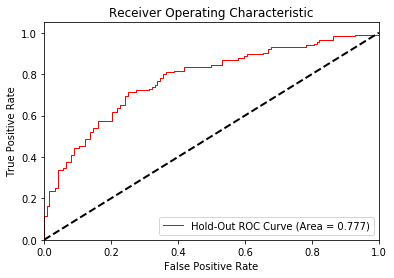

In [33]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.777


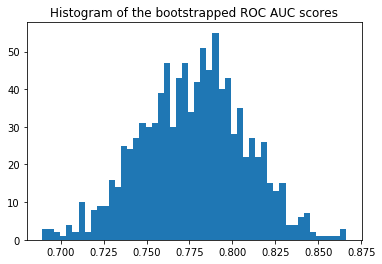

Confidence interval for the score: [0.716 - 0.835]


In [34]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

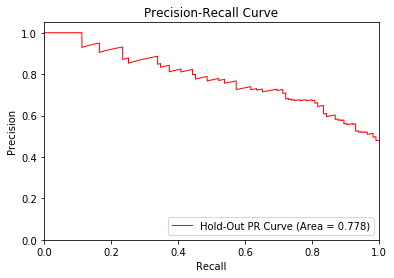

In [35]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.778


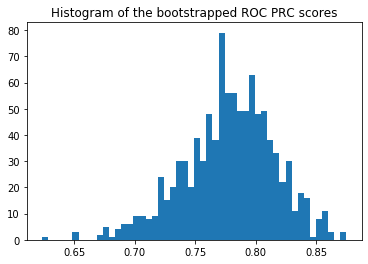

Confidence interval for the score: [0.696 - 0.851]


In [36]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))